In [1]:
import datetime
import os
import cv2
import numpy as np
import torch
import random
from dataset import EICDataset, Resizer, Normalizer, collater, RandAugment, Windowing
from dcm import windowing, get_windowing
import pydicom
import gc

from torch import nn
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torchvision.models import *
from torchio import transforms as tio_transforms

import pytorch_lightning as pl
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger
import torchmetrics

from tqdm.autonotebook import tqdm
from glob import glob
import pandas as pd

import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
import csv
import warnings
import math
from sklearn.metrics import roc_auc_score

from grad_cam import *
from grad_cam.utils import device 
from utils import *
from loss import FocalLoss, Weighted_Binary_Cross_Entropy
from efficientnet.model import EfficientNet

warnings.filterwarnings(action='ignore')
%matplotlib inline
#torch.autograd.set_detect_anomaly(True)

# Hyperparameter

In [2]:
# Hyperparameters, first modify project, sub_project, WC, WW
opt = {
    'project':'eic',
    'sub_project':'w4080_dect_norm',
    'compound_coef':4,
    'num_workers':8,
    'num_gpus':1,
    'batch_size':16*torch.cuda.device_count(),
    'test_batch_size':1,
    'input_size':[512,256],
    'lr':1e-3,
    'val_rate':0.1,
    'num_epochs':80,
    'swa':True,
    'precision':16,
    'data_path':"D:/AJ_Eval_DATA_hemi_v3/manual_dataset_dect_norm_dcm/",
    'log_path':'tensorboard/',
    'saved_path':'weights/',
    'load_weights':'C:/Users/gyuha/Desktop/cASPECTS/EfficientNet_hemi/weights/eic/w4080_tlhm/1/efficientnet-d4_9_10790.pth',
    'Windowing':windowing,
    'WC':40,
    'WW':80,
    'mean':[10.604362079468231, 10.604362079468231, 10.604362079468231],
    'std':[15.79586109964471, 15.79586109964471, 15.79586109964471],
}

# Cuda
no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
Tensor = torch.cuda.FloatTensor if use_cuda else torch.Tensor
if use_cuda:
    torch.cuda.manual_seed(42)
else:
    torch.manual_seed(42)

# Generator parameters
training_params = {'batch_size': opt['batch_size'],
                   'shuffle': True,
                   'drop_last': True,
                   'collate_fn': collater,
                   'num_workers': opt['num_workers']}

val_params = {'batch_size': opt['batch_size'],
              'shuffle': True,
              'drop_last': False,
              'collate_fn': collater,
              'num_workers': opt['num_workers']}

test_params = {'batch_size': opt['test_batch_size'],
              'shuffle': False,
              'drop_last': False,
              'collate_fn': collater,
              'num_workers': opt['num_workers']}

# Set path
opt['saved_path'] = opt['saved_path'] + '{}/{}/'.format(opt['project'],opt['sub_project'])
os.makedirs(opt['saved_path'], exist_ok=True)
opt['log_path'] = opt['log_path'] + '{}/{}/'.format(opt['project'],opt['sub_project'])
os.makedirs(opt['log_path'], exist_ok=True)

os.makedirs('./test/{}/{}/TP'.format(opt['project'],opt['sub_project']), exist_ok=True)
os.makedirs('./test/{}/{}/FP'.format(opt['project'],opt['sub_project']), exist_ok=True)
os.makedirs('./test/{}/{}/TN'.format(opt['project'],opt['sub_project']), exist_ok=True)
os.makedirs('./test/{}/{}/FN'.format(opt['project'],opt['sub_project']), exist_ok=True)

# Preprocessing

### - Divide dataset

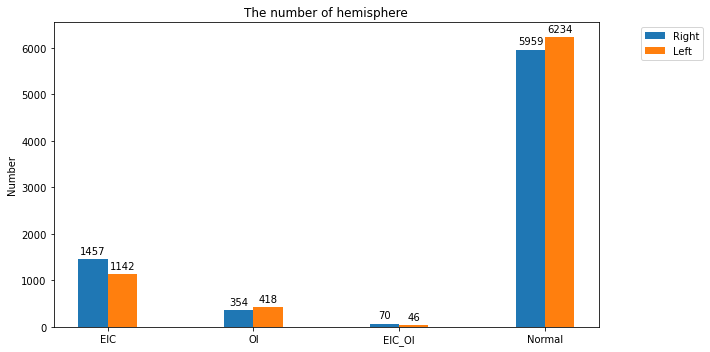

In [3]:
# Load path
train_right_eic = glob(opt['data_path']+'train/eic_right/*.dcm')
train_right_oi = glob(opt['data_path']+'train/oi_right/*.dcm')
train_right_eic_oi = glob(opt['data_path']+'train/eic+oi_right/*.dcm')
train_right_normal = glob(opt['data_path']+'train/normal_right/*.dcm')
train_left_eic = glob(opt['data_path']+'train/eic_left/*.dcm')
train_left_oi = glob(opt['data_path']+'train/oi_left/*.dcm')
train_left_eic_oi = glob(opt['data_path']+'train/eic+oi_left/*.dcm')
train_left_normal = glob(opt['data_path']+'train/normal_left/*.dcm')

test_right_eic = glob(opt['data_path']+'test/eic_right/*.dcm')
test_right_oi = glob(opt['data_path']+'test/oi_right/*.dcm')
test_right_eic_oi = glob(opt['data_path']+'test/eic+oi_right/*.dcm')
test_right_normal = glob(opt['data_path']+'test/normal_right/*.dcm')
test_left_eic = glob(opt['data_path']+'test/eic_left/*.dcm')
test_left_oi = glob(opt['data_path']+'test/oi_left/*.dcm')
test_left_eic_oi = glob(opt['data_path']+'test/eic+oi_left/*.dcm')
test_left_normal = glob(opt['data_path']+'test/normal_left/*.dcm')
    
plot_dataset(train_right_eic+test_right_eic, train_right_oi+test_right_oi,\
             train_right_eic_oi+test_right_eic_oi, train_right_normal+test_right_normal,\
             train_left_eic+test_left_eic, train_left_oi+test_left_oi,\
             train_left_eic_oi+test_left_eic_oi, train_left_normal+test_left_normal)

### - Get mean, std

In [4]:
# image_paths = train_right_eic+test_right_eic+train_right_oi+test_right_oi+\
#               train_right_eic_oi+test_right_eic_oi+train_right_normal+test_right_normal+\
#               train_left_eic+test_left_eic+train_left_oi+test_left_oi+\
#               train_left_eic_oi+test_left_eic_oi+train_left_normal+test_left_normal

# data_set = EICDataset(image_paths, transforms.Compose([
#                                          RandAugment(3),  # Flip, Brightness, Elastic, Zoom, Blur
#                                          Resizer(opt['input_size']),
#                                          Windowing(windowing=opt['Windowing'],WC=opt['WC'],WW=opt['WW'],rescale=False),
#                                     ]))

# image_std = [0,0,0]
# image_mean = [0,0,0]

# for i in range(len(data_set)):
#     data = data_set.__getitem__(i)
#     image = data['img']
    
#     for j in range(len(image_std)):
#         image_mean[j] += image[:,:,j].mean()
#         image_std[j] += image[:,:,j].std()
        
# opt['mean'] = [image_mean[0]/len(image_paths), image_mean[1]/len(image_paths), image_mean[2]/len(image_paths)]
# opt['std'] = [image_std[0]/len(image_paths), image_std[1]/len(image_paths), image_std[2]/len(image_paths)]

# print('mean: {}\nstd: {}'.format(opt['mean'], opt['std']))

### - Transform

In [5]:
training_transform = transforms.Compose([
                                         RandAugment(3),  # Flip, Brightness, Elastic, Zoom, Blur
                                         Resizer(opt['input_size']),
                                         Windowing(windowing=opt['Windowing'],WC=opt['WC'],WW=opt['WW'],rescale=False),
                                         Normalizer(mean=opt['mean'], std=opt['std']),
                                        ])

val_transform = transforms.Compose([
                                    Resizer(opt['input_size']),
                                    Windowing(windowing=opt['Windowing'],WC=opt['WC'],WW=opt['WW'],rescale=False),
                                    Normalizer(mean=opt['mean'], std=opt['std'])
                                   ])

test_transform = transforms.Compose([
                                     Resizer(opt['input_size']),
                                     Windowing(windowing=opt['Windowing'],WC=opt['WC'],WW=opt['WW'],rescale=False),
                                     Normalizer(mean=opt['mean'], std=opt['std'])
                                    ])

### - Visualization

In [6]:
training_set = EICDataset(train_right_eic,
                           transform=training_transform)

tensor([1.])


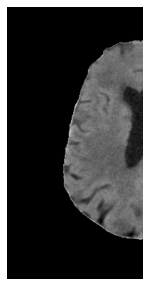

In [7]:
### Get specific train images
data = training_set.__getitem__(30) # Convert to 4d tensor (BxNxHxW)
image = data['img']
image = (image - image.min()) / (image.max() - image.min())
print(data['annot'])
fig, ax0 = plt.subplots(figsize=(5,5))
ax0.imshow(image,'gray')
ax0.axis('off');

# Train

### - Dataset

In [8]:
# eic+oi eic O
train_eic_image_paths = train_right_eic + train_left_eic + train_right_eic_oi + train_left_eic_oi
# oi noraml X
train_normal_image_paths = train_right_oi + train_left_oi + train_right_normal + train_left_normal

val_image_paths = test_right_eic + test_left_eic + test_right_oi + test_left_oi + \
                  test_right_eic_oi + test_left_eic_oi + test_right_normal + test_left_normal

# Updata dataset
training_eic_set = EICDataset(train_eic_image_paths, transform=training_transform)
for trans_num in range(4): # 5 times
    add_set = EICDataset(train_eic_image_paths, transform=training_transform)
    training_eic_set = training_eic_set + add_set

training_normal_set = EICDataset(train_normal_image_paths, transform=training_transform)

training_set = training_eic_set + training_normal_set

val_set = EICDataset(val_image_paths, transform=val_transform)      

print('training eic set:{}\ttraining normal set:{}'.format(len(training_eic_set),len(training_normal_set)))

# Update generator
training_generator = DataLoader(training_set, **training_params)
val_generator = DataLoader(val_set, **val_params)

training eic set:12230	training normal set:11698


### - Lightning module

In [9]:
class Solver(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # Load pretrained model
        model = EfficientNet.from_pretrained('efficientnet-b{}'.format(opt['compound_coef']))
        model._fc = torch.nn.Linear(1792, 1)
        model.to(device)
        model.load_state_dict(torch.load(opt['load_weights']))
        
        # Model
        self.model = model

        # Criterion
        self.criterion = nn.BCEWithLogitsLoss()
        
        # Metric
        self.Accuracy = torchmetrics.Accuracy()
        self.Precision = torchmetrics.Precision()
        self.Sensitivity = torchmetrics.Recall()
        self.Specificity = torchmetrics.Specificity()
        self.AUC = torchmetrics.AUROC(pos_label=1)

    def forward(self, x):
        out = self.model(x)
        return out

    def training_step(self, batch, batch_idx):
        x = batch['img']
        y = batch['annot']
        
        pred = self(x)
        loss = self.criterion(pred, y)
                
        # Tensorboard log
        self.logger.experiment.add_scalar('Train/Loss', loss, self.trainer.global_step)
        
        # Log for callbacks
        self.log('iteration', self.trainer.global_step, on_step=True, on_epoch=False, prog_bar=True, logger=False)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x = batch['img']
        y = batch['annot']
        
        pred = self(x)
        loss = self.criterion(pred, y)
        
        return {'Loss': loss, 'GT': y.detach(), 'Pred': torch.sigmoid(pred).detach()}
        
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['Loss'] for x in outputs]).mean()
        gt = torch.cat([x['GT'] for x in outputs]).long()
        pred = torch.cat([x['Pred'] for x in outputs])
        
        # Metric
        accuracy = self.Accuracy(pred, gt)
        precision = self.Precision(pred, gt)
        sensitivity = self.Sensitivity(pred, gt)
        specificity = self.Specificity(pred, gt)
        auc = self.AUC(pred, gt)
                
        # Tensorboard log
        self.logger.experiment.add_scalar('Val/Loss', avg_loss, self.trainer.global_step)
        self.logger.experiment.add_scalar('Val/Accuracy', accuracy, self.trainer.global_step)
        self.logger.experiment.add_scalar('Val/Precision', precision, self.trainer.global_step)
        self.logger.experiment.add_scalar('Val/Sensitivity', sensitivity, self.trainer.global_step)
        self.logger.experiment.add_scalar('Val/Specificity', specificity, self.trainer.global_step)
        self.logger.experiment.add_scalar('Val/AUC', auc, self.trainer.global_step)
        
        del outputs
        torch.cuda.empty_cache()
        
        # Log for callbakcs
        self.log('AUC', auc, on_step=False, on_epoch=True, prog_bar=False, logger=False)
        
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(filter(lambda x: x.requires_grad, self.parameters()), opt['lr'])            
        lr_scheduler = {'scheduler': torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                                            T_0=int(len(training_generator)*opt['num_epochs']/31),
                                                                            T_mult=2, eta_min=0),
                        'name': 'learning_rate',
                        'interval':'step',
                        'frequency': 1}
        
        return [optimizer], [lr_scheduler]

### - Log

In [10]:
# PL Callbacks
tb_logger = TensorBoardLogger(save_dir=opt['log_path']+'{}/'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")),
                              name=None)

# Checkpoint
checkpointing = pl.callbacks.ModelCheckpoint(
    dirpath=opt['saved_path'],
    filename='iter{iteration:.0f}_auc{AUC:.2f}',
    save_last=True,
    save_top_k=20,
    monitor='AUC',
    mode='max',
    auto_insert_metric_name=False
)

# Learning rate monitor
lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval='step')

### - Train

In [ ]:
os.makedirs(opt['log_path'], exist_ok=True)
os.makedirs(opt['saved_path'], exist_ok=True)

trainer = pl.Trainer(max_epochs=opt['num_epochs'],
                     num_sanity_val_steps=0,
                     gpus=opt['num_gpus'],
                     callbacks=[checkpointing, lr_monitor],
                     logger=tb_logger,
                     precision= 16 if opt['precision'] == 16 else 32,
                     stochastic_weight_avg=opt['swa'])

model = Solver()

# Start Training!
trainer.fit(model, training_generator, val_generator)

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Loaded pretrained weights for efficientnet-b4


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type              | Params
--------------------------------------------------
0 | model       | EfficientNet      | 17.6 M
1 | criterion   | BCEWithLogitsLoss | 0     
2 | Accuracy    | Accuracy          | 0     
3 | Precision   | Precision         | 0     
4 | Sensitivity | Recall            | 0     
5 | Specificity | Specificity       | 0     
6 | AUC         | AUROC             | 0     
--------------------------------------------------
17.6 M    Trainable params
0         Non-trainable params
17.6 M    Total params
70.202    Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

# Save Results

### - Test dataset

In [10]:
# Load fold images
test_images = test_right_eic+test_right_oi+test_right_eic_oi+test_right_normal+\
              test_left_eic+test_left_oi+test_left_eic_oi+test_left_normal
test_set = EICDataset(test_images, transform=test_transform)
test_generator = DataLoader(test_set, **test_params)

### - Save images

Loaded pretrained weights for efficientnet-b4
Accuracy: 0.8503. Precision: 0.5600. Recall: 0.6766. Specificity: 0.8871. AUC: 0.8898
TP: 182    TN: 1124    FP: 143    FN: 87


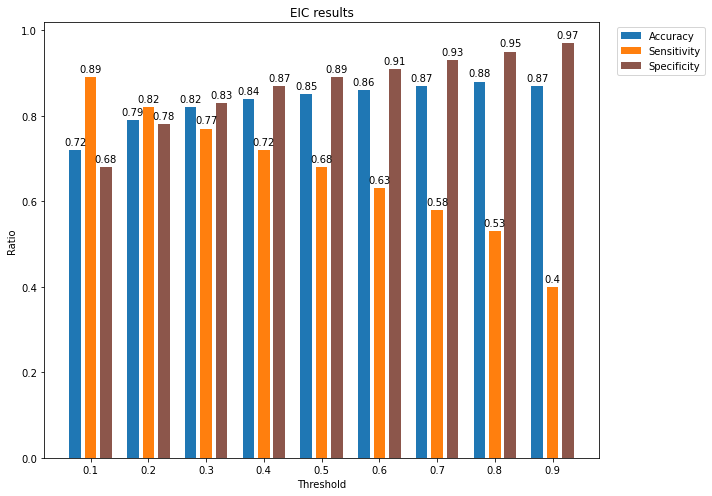

In [11]:
# Load model
weight_path = opt['saved_path'] + 'iter16444_auc0.89.ckpt'
model = Solver.load_from_checkpoint(weight_path)
model.to(device)
model.eval()
Grad_CAM = GradCam(model.model, device)

eps = 1e-10

tp = 0
fp = 0
tn = 0
fn = 0

true = []
pred = []

EIC_results = [['ID','Slice','lateral','GT_EIC','Pred_EIC']]

for iter, data in enumerate(test_generator):

    dataset = pydicom.read_file(test_images[iter])
    ori_img = dataset.pixel_array
    _, _, intercept, slope = get_windowing(dataset)
    ori_img = (ori_img * slope + intercept)
    ori_img = ori_img
    ori_img = windowing(ori_img, opt['WC'], opt['WW'],rescale=True)
    ori_img = np.stack((ori_img,ori_img,ori_img),axis=-1)

    x = test_images[iter].split('\\')
    filename = x[-1]
    if test_images[iter].split('/')[-1].split('\\')[0].split('_')[-1]=='right':
        lateral = 'R'
    else: lateral = 'L'
    HR = x[-1][0:3]
    
    img = data['img'].to(device, dtype=torch.float32)
    annot = data['annot'].to(device)       
    predicted = torch.sigmoid(model(img))

    if annot==1:
        gt='EIC'
    else: gt='Normal'
    
    cam_img = tensor2img(Grad_CAM(img, model.model._blocks[31]._expand_conv)[0])
    cam_img = ((cam_img - cam_img.min()) / (cam_img.max() - cam_img.min()))

    true.append(annot[0].detach().cpu()[0])
    pred.append(predicted[0].detach().cpu()[0])
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,5), clear=True)
    ax0.imshow(ori_img)
    ax0.set_title('Ground Truth: {}'.format(gt))
    ax1.imshow(cam_img)
    ax1.set_title('Pred: {:.4f}'.format(predicted.cpu().detach().numpy()[0][0]))
    plt.close(fig)
    
    EIC_results.append([HR,filename,lateral,gt,predicted.cpu().detach().numpy()[0][0]])
    
    # Save image    
    if annot==1 and predicted[0][0].round()==1:
        tp+=1
        fig.savefig('./test/{}/{}/TP/{}_{}.png'.format(opt['project'],opt['sub_project'],filename[:-4],lateral), dpi=150)
    elif annot==1 and predicted[0][0].round()==0:
        fn+=1
        fig.savefig('./test/{}/{}/FN/{}_{}.png'.format(opt['project'],opt['sub_project'],filename[:-4],lateral), dpi=150)
    elif annot==0 and predicted[0][0].round()==0:
        tn+=1
        fig.savefig('./test/{}/{}/TN/{}_{}.png'.format(opt['project'],opt['sub_project'],filename[:-4],lateral), dpi=150)
    else:
        fp+=1
        fig.savefig('./test/{}/{}/FP/{}_{}.png'.format(opt['project'],opt['sub_project'],filename[:-4],lateral), dpi=150)

print('Accuracy: {:.4f}. Precision: {:.4f}. Recall: {:.4f}. Specificity: {:.4f}. AUC: {:.4f}'.format(
                               (tp+tn)/(tp+tn+fp+fn+eps), tp/(tp+fp+eps),
                               tp/(tp+fn+eps), tn/(tn+fp+eps), roc_auc_score(true,pred)))
print('TP: {}    TN: {}    FP: {}    FN: {}'.format(tp,tn,fp,fn))

tp, tn, fp, fn = plot_results(true, pred, title='EIC results')

In [12]:
df = pd.DataFrame(EIC_results)
df.to_csv('./results/{}_A_results(210915).csv'.format(opt['sub_project']), index=False, header=False)

### - Save weight

In [14]:
torch.save(model.model.state_dict(),'./weights/{}_{}.pth'.format(opt['project'],opt['sub_project']))

Loaded pretrained weights for efficientnet-b4


# Test Gil

### - Save CAM and probability

In [10]:
HR_list = os.listdir('D:/TestSET_cELVO_210913')[1:]
csv = pd.read_excel('D:/TestSET_cELVO_210913/Annotation_GH_cELVO_v2.xlsx')

In [ ]:
weight_path = opt['saved_path'] + 'iter16444_auc0.89.ckpt'
model = Solver.load_from_checkpoint(weight_path)
model.to(device)
model.eval()
Grad_CAM = GradCam(model.model, device)

r_pred = []
l_pred = []
EIC_results = [['ID','Slice','GT_LVO','Pred_EIC']]

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,5), clear=True)

for HR in HR_list:
    HR_r_pred = []
    HR_l_pred = []
    
    if csv.loc[csv['Name']==HR,'Class1'].tolist()[0]=='LVO_R':
        gt = 'R'
    elif csv.loc[csv['Name']==HR,'Class2'].tolist()[0]=='LVO_L':
        gt = 'L'
    else: gt = 'N'
    
    right_dcm = glob('D:/TestSET_cELVO_210913/{}/ELVO/RH/*dcm'.format(HR))
    left_dcm = glob('D:/TestSET_cELVO_210913/{}/ELVO/LH/*dcm'.format(HR))
    
    for path in right_dcm:
        dataset = pydicom.read_file(path, force=True)
        dataset.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        
        image = dataset.pixel_array.astype(np.float32)
    
        # windowing 파라미터 획득
        _, _, intercept, slope = get_windowing(dataset)
        
        # rescale 수행
        image = (image * slope + intercept)
        t_image = test_transform(image).unsqueeze(0).permute(0,3,1,2)
        pred = torch.sigmoid(model(t_image.to(device, dtype=torch.float32)))
        
        HR_r_pred.append(pred.cpu().detach().numpy())
        EIC_results.append([HR, path.split('\\')[-1], gt, pred.cpu().detach().numpy()[0][0]])
        
        # Grad-CAM
        cam_img = tensor2img(Grad_CAM(t_image, model.model._blocks[31]._expand_conv)[0])
        cam_img = ((cam_img - cam_img.min()) / (cam_img.max() - cam_img.min()))

        t_image_save = ((t_image - t_image.min()) / (t_image.max() - t_image.min())).permute(0,2,3,1)[0].cpu().detach().numpy()
        
        os.makedirs('Z:/Stroke/SharingFolder/cELVO/EIC_CAM/{}/{}/RH'.format(opt['sub_project'],HR),exist_ok=True)
        
        ax0.imshow(t_image_save)
        ax0.set_title('Ground Truth: LVO-{}'.format(gt))
        ax1.imshow(cam_img)
        ax1.set_title('Pred: {:.4f}'.format(pred.cpu().detach().numpy()[0][0]))
        fig.savefig('Z:/Stroke/SharingFolder/cELVO/EIC_CAM/{}/{}/RH/{}.png'.format(opt['sub_project'],
                                                                                          HR,path.split('\\')[-1][:-4]), dpi=150)
        plt.close()
        
    for path in left_dcm:
        dataset = pydicom.read_file(path, force=True)
        dataset.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        
        image = dataset.pixel_array.astype(np.float32)
    
        # windowing 파라미터 획득
        _, _, intercept, slope = get_windowing(dataset)
        
        # rescale 수행
        image = (image * slope + intercept)
        t_image = test_transform(image).unsqueeze(0).permute(0,3,1,2)
        pred = torch.sigmoid(model(t_image.to(device, dtype=torch.float32)))
        
        HR_l_pred.append(pred.cpu().detach().numpy())
        EIC_results.append([HR, path.split('\\')[-1], gt, pred.cpu().detach().numpy()[0][0]])

        # Grad-CAM
        cam_img = tensor2img(Grad_CAM(t_image, model.model._blocks[31]._expand_conv)[0])
        cam_img = ((cam_img - cam_img.min()) / (cam_img.max() - cam_img.min()))

        t_image_save = ((t_image - t_image.min()) / (t_image.max() - t_image.min())).permute(0,2,3,1)[0].cpu().detach().numpy()
        
        os.makedirs('Z:/Stroke/SharingFolder/cELVO/EIC_CAM/{}/{}/LH'.format(opt['sub_project'],HR),exist_ok=True)
        
        ax0.imshow(t_image_save)
        ax0.set_title('Ground Truth: LVO-{}'.format(gt))
        ax1.imshow(cam_img)
        ax1.set_title('Pred: {:.4f}'.format(pred.cpu().detach().numpy()[0][0]))
        fig.savefig('Z:/Stroke/SharingFolder/cELVO/EIC_CAM/{}/{}/LH/{}.png'.format(opt['sub_project'],
                                                                                          HR,path.split('\\')[-1][:-4]), dpi=150)
        plt.close()
        
    r_pred.append(HR_r_pred)
    l_pred.append(HR_l_pred)        

Loaded pretrained weights for efficientnet-b4


In [12]:
df = pd.DataFrame(EIC_results)
df.to_csv('./results/{}_G_results(210915).csv'.format(opt['sub_project']), index=False, header=False)

### - Test Gil LVO

In [3]:
csv = pd.read_csv('./results/{}_G_results(210915).csv'.format(opt['sub_project']))

id = csv['ID']
id = id.drop_duplicates()
HR_list = id.to_list()

In [55]:
HR_r_pred = []
HR_l_pred = []
gt_lvo = []

for HR in HR_list:
    gt_lvo.append(csv.loc[csv['ID']==HR,'GT_LVO'].tolist()[0])
    dcm_list = csv.loc[csv['ID']==HR,'Slice'].tolist()
    r_dcm_list = dcm_list[:int(len(dcm_list)/2)]
    l_dcm_list = dcm_list[int(len(dcm_list)/2):]

    r_pred = []
    l_pred = []

    for dcm in r_dcm_list:
        r_pred.append(csv.loc[(csv['ID']==HR) & (csv['Slice']==dcm),'Pred_EIC'].tolist()[0])
    for dcm in l_dcm_list:
        l_pred.append(csv.loc[(csv['ID']==HR) & (csv['Slice']==dcm),'Pred_EIC'].tolist()[0])
        
    HR_r_pred.append(r_pred)
    HR_l_pred.append(l_pred)

In [70]:
threshold = 0.915

pred_lvo = []

for i in range(len(HR_list)):
    gt = gt_lvo[i]
    r_max = np.array(HR_r_pred[i]).max()
    l_max = np.array(HR_l_pred[i]).max()
    
    if r_max >= threshold or l_max >= threshold:
        if r_max >= l_max:
            pred = 'R'
        else: pred= 'L'
    else: pred = 'N'
        
    pred_lvo.append(pred)

In [53]:
tp = 0
tn = 0
fp = 0
fn = 0
eps=1e-10

for i in range(len(HR_list)):
    if pred_lvo[i]=='R' and gt_lvo[i]=='R':
        tp+=1
    elif pred_lvo[i]=='L' and gt_lvo[i]=='L':
        tp+=1
    elif pred_lvo[i]=='R' and (gt_lvo[i]=='L' or gt_lvo[i]=='N'):
        fp+=1
    elif pred_lvo[i]=='L' and (gt_lvo[i]=='R' or gt_lvo[i]=='N'):
        fp+=1
    elif pred_lvo[i]=='N' and gt_lvo[i]=='N':
        tn+=1
    elif pred_lvo[i]=='N' and (gt_lvo[i]=='R' or gt_lvo[i]=='L'):
        fn+=1
        
print('Accuracy: {:.4f}. Precision: {:.4f}. Sensitivity: {:.4f}. Specificity: {:.4f}'.format(
                               (tp+tn)/(tp+tn+fp+fn+eps), tp/(tp+fp+eps),
                               tp/(tp+fn+eps), tn/(tn+fp+eps)))

Accuracy: 0.6364. Precision: 0.3708. Sensitivity: 0.6226. Specificity: 0.6410
